In [207]:
import sqlite3 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, accuracy_score, recall_score, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import optuna


import scipy.stats 
from scipy.stats import chi2_contingency, kruskal

conn = sqlite3.connect("/Users/kelvinfoo/Desktop/AISG Technical Assignments/Hotel Noshow Prediction/noshow.db")
df = pd.read_sql_query('SELECT * FROM noshow', conn)
df.head()

/Users/kelvinfoo/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,94113,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,SGD$ 492.98,Website,1,0.0
1,86543,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0.0
2,75928,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,None,Agent,1,0.0
3,66947,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,SGD$ 666.04,Website,1,0.0
4,106390,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,USD$ 665.37,Website,1,0.0


#### **Types of features in df:**
**1. Categorical**
- no_show: Whether the customer showed up for his reservation. 
- branch
- booking_month
- arrival_month
- arrival_day 
- checkout_month
- checkout_day 
- country: Where the customer came from.
- first_time: Whether it was the customer's first time at the hotel. 
- room
- platform: The platform where the customer reserved the hotel.

**2. Numerical**
- price: Price (per night) for the room booked. 
- num_adults
- num_children

### **Dealing with Duplicate Records**

In [136]:
print(f"There were {df.shape[0]} rows and there were {df['booking_id'].nunique()} unique booking IDs in df. Hence, no booking ID was repeated twice.")

There were 119391 rows and there were 119391 unique booking IDs in df. Hence, no booking ID was repeated twice.


In [137]:
df_no_id = df.drop('booking_id', axis = 1) # Booking ID has no purpose in EDA and model building.

# Check for duplicates 
df_no_id.duplicated().value_counts()

False    118577
True        814
Name: count, dtype: int64

In [138]:
df_no_id[df_no_id.duplicated() == True].sort_values(['branch', 'booking_month', 'arrival_month', 'arrival_day']).head(10)

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
34121,1.0,Changi,April,April,13.0,April,14.0,China,Yes,King,None,Website,1,0.0
98808,0.0,Changi,April,April,17.0,April,18.0,Japan,Yes,King,None,Agent,1,2.0
114041,0.0,Changi,April,April,17.0,April,18.0,Indonesia,Yes,King,None,Website,2,0.0
65463,1.0,Changi,April,April,21.0,April,23.0,China,Yes,King,None,Agent,1,2.0
37829,1.0,Changi,April,April,26.0,April,29.0,China,Yes,King,None,Website,2,0.0
74513,1.0,Changi,April,April,26.0,April,29.0,China,Yes,King,None,Website,2,0.0
82615,1.0,Changi,April,April,26.0,April,29.0,China,Yes,King,None,Website,2,2.0
104195,1.0,Changi,April,April,26.0,April,29.0,China,Yes,King,None,Website,2,2.0
107744,1.0,Changi,April,April,26.0,April,29.0,China,Yes,King,None,Website,1,1.0
55479,0.0,Changi,April,August,3.0,August,4.0,Indonesia,Yes,King,None,Website,1,0.0


- After disregarding the booking ID, there were 814 duplicate booking records.
- We will drop the duplicate booking records to prevent data leakage when training machine learning models.

In [139]:
df = df_no_id.drop_duplicates()
print(f"There were {df.shape[0]} rows after the removal of duplicate booking records.")

There were 118577 rows after the removal of duplicate booking records.


### **Dealing with Missing Records**

In [140]:
# Number of missing records in each column
df.isna().sum()

no_show               1
branch                1
booking_month         1
arrival_month         1
arrival_day           1
checkout_month        1
checkout_day          1
country               1
first_time            1
room              21613
price             24068
platform              1
num_adults            1
num_children          1
dtype: int64

In [141]:
df[df['no_show'].isna() == True]

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
111598,NaN,None,None,None,NaN,None,NaN,None,None,None,None,None,None,NaN


In [142]:
# Drop this row since all features are null 
df = df[df['no_show'].isna() == False]
df.isna().sum()

no_show               0
branch                0
booking_month         0
arrival_month         0
arrival_day           0
checkout_month        0
checkout_day          0
country               0
first_time            0
room              21612
price             24067
platform              0
num_adults            0
num_children          0
dtype: int64

- There were only two features with missing values: room and price.

In [143]:
df[(df['price'].isna() == False) & (df['room'].isna() == False)]

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,SGD$ 492.98,Website,1,0.0
1,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0.0
3,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,SGD$ 666.04,Website,1,0.0
4,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,USD$ 665.37,Website,1,0.0
6,0.0,Orchard,November,October,15.0,October,16.0,Australia,Yes,King,SGD$ 1375.44,Website,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119384,0.0,Changi,April,June,11.0,June,12.0,China,Yes,King,USD$ 605.91,Agent,1,0.0
119386,0.0,Changi,September,April,3.0,April,5.0,China,Yes,King,USD$ 612.18,Website,1,1.0
119387,0.0,Orchard,March,December,30.0,January,3.0,China,Yes,King,USD$ 1041.29,Email,2,0.0
119388,1.0,Changi,September,March,31.0,April,1.0,Indonesia,Yes,King,USD$ 641.47,Email,1,2.0


- Branch, room type, platform (websites might offer discounts compared to agent), number of adults and children, duration between booking month and arrival month, arrival month (prices might be higher during holiday seasons) are factors that can affect the price. 
- Price, branch, number of adults and children were factors to consider in the imputation of room type.
- Note that prices were in different currencies. It was necessary to convert price to a standard currency (eg. SGD) before carrying out any imputation. The conversion was based on the following exchange rate: 1 USD = 1.35 SGD. 

In [144]:
df['currency'] = df['price'].astype(str).str[0:3]
df['price'] = df['price'].astype(str).str[4:]
df['price'] = pd.to_numeric(df['price'], errors = 'coerce')

# Currencies were only in SGD and USD
df['currency'].value_counts()

# Conversion of USD to SGD
df['price'] = df.apply(lambda x: x['price'] * 1.35 if x['currency'] == 'USD' else x['price'], axis = 1)
df.drop(['currency'], axis = 1)

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,492.9800,Website,1,0.0
1,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,1351.2200,Website,2,0.0
2,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,NaN,Agent,1,0.0
3,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,666.0400,Website,1,0.0
4,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,898.2495,Website,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119386,0.0,Changi,September,April,3.0,April,5.0,China,Yes,King,826.4430,Website,1,1.0
119387,0.0,Orchard,March,December,30.0,January,3.0,China,Yes,King,1405.7415,Email,2,0.0
119388,1.0,Changi,September,March,31.0,April,1.0,Indonesia,Yes,King,865.9845,Email,1,2.0
119389,0.0,Changi,February,February,25.0,February,27.0,China,Yes,None,886.3500,Website,2,0.0


In [145]:
# Rows where price is null and room type is not null 
df[(df['price'].isna() == True) & (df['room'].isna() == False)]

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children,currency
2,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,NaN,Agent,1,0.0,Non
7,0.0,Changi,July,November,18.0,November,19.0,India,Yes,King,NaN,Email,2,1.0,Non
15,0.0,Orchard,December,August,13.0,August,15.0,India,Yes,Queen,NaN,Phone,1,1.0,Non
16,0.0,Changi,December,February,22.0,February,23.0,Indonesia,Yes,King,NaN,Website,2,2.0,Non
18,0.0,Changi,June,July,30.0,July,31.0,Japan,Yes,King,NaN,Agent,two,2.0,Non
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119362,1.0,Changi,June,January,16.0,January,18.0,Japan,Yes,King,NaN,Website,2,0.0,Non
119364,0.0,Changi,April,September,4.0,September,5.0,Malaysia,Yes,King,NaN,Agent,1,2.0,Non
119367,0.0,Changi,May,September,3.0,September,4.0,Japan,Yes,King,NaN,Website,1,2.0,Non
119374,0.0,Changi,January,February,15.0,February,-16.0,India,Yes,Single,NaN,Website,1,1.0,Non


#### **Dealing with missing Room Records**

In [146]:
df['room'].value_counts()

room
King               69743
Single             15647
Queen              10813
President Suite      761
Name: count, dtype: int64

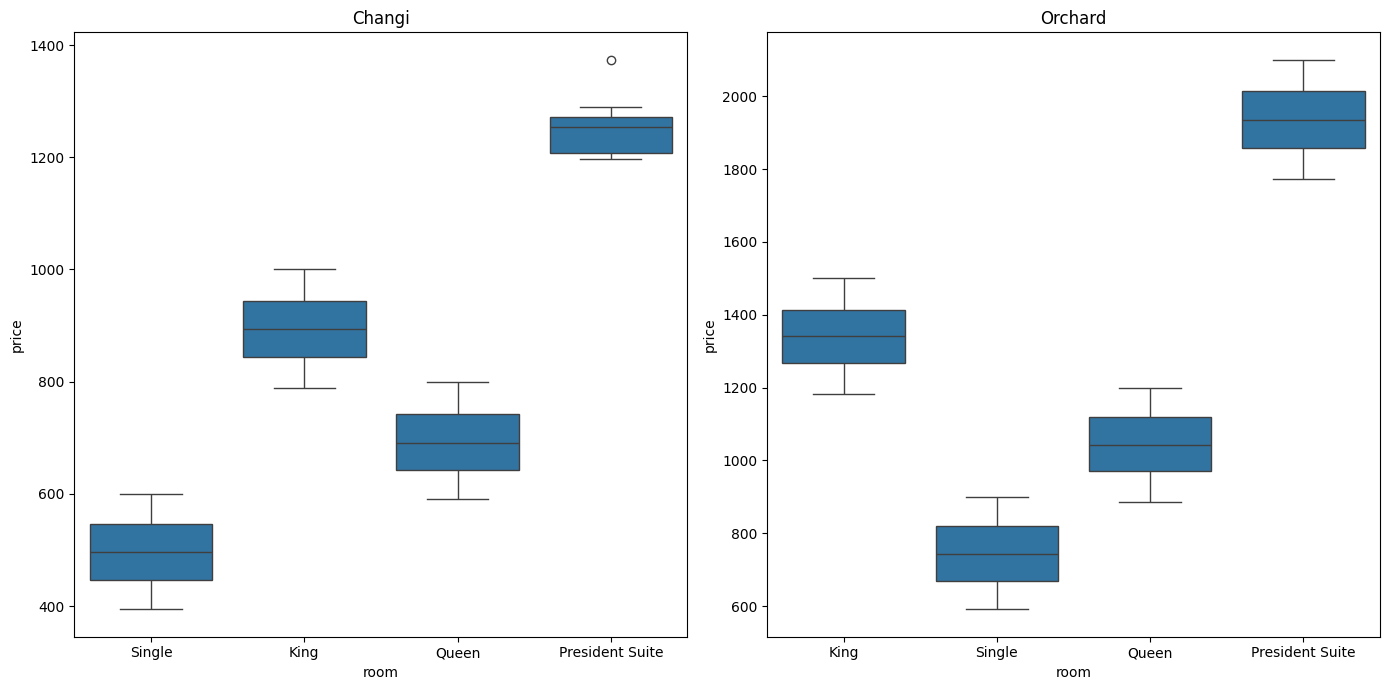

In [147]:
df_changi = df[df['branch'] == 'Changi']
df_orchard = df[df['branch'] == 'Orchard']


fig, axes = plt.subplots(1, 2, figsize=(14, 7))

sns.boxplot(ax=axes[0], x='room', y='price', data=df_changi)
axes[0].set_title('Changi')

sns.boxplot(ax=axes[1], x='room', y='price', data=df_orchard)
axes[1].set_title('Orchard')

plt.tight_layout()
plt.show()

Based on the boxplot, we inferred the room type based on the following logic: 
1. If branch is Changi: 
- If price <= 600, then Single.
- If 600 < price <= 800. then Queen.
- If 800 < price <= 1200, then King. 
- Else, President Suite. 

2. If branch is Orchard, 
- If price <= 900, then Single. 
- If 900 < price <= 1200, then Queen. 
- If 1200 < price < 1800, then King
- Else, President Suite. 

In [148]:
conditions_changi = [
    (df['branch'] == 'Changi') & (df['price'] <= 600) & df['room'].isna(),
    (df['branch'] == 'Changi') & (df['price'] > 600) & (df['price'] <= 800) & df['room'].isna(),
    (df['branch'] == 'Changi') & (df['price'] > 800) & (df['price'] <= 1200) & df['room'].isna(),
    (df['branch'] == 'Changi') & (df['price'] > 1200) & df['room'].isna()
]

choices_changi = ['Single', 'Queen', 'King', 'President Suite']

conditions_orchard = [
    (df['branch'] == 'Orchard') & (df['price'] <= 900) & df['room'].isna(),
    (df['branch'] == 'Orchard') & (df['price'] > 900) & (df['price'] <= 1200) & df['room'].isna(),
    (df['branch'] == 'Orchard') & (df['price'] > 1200) & (df['price'] < 1800) & df['room'].isna(),
    (df['branch'] == 'Orchard') & (df['price'] >= 1800) & df['room'].isna()
]

choices_orchard = ['Single', 'Queen', 'King', 'President Suite']

conditions = conditions_changi + conditions_orchard
choices = choices_changi + choices_orchard

df['room'] = np.select(conditions, choices, default=df['room'])
df.isna().sum()

no_show               0
branch                0
booking_month         0
arrival_month         0
arrival_day           0
checkout_month        0
checkout_day          0
country               0
first_time            0
room                  0
price             24067
platform              0
num_adults            0
num_children          0
currency              0
dtype: int64

#### **Dealing with Missing Price Records**
- Branch, room type, platform (websites might offer discounts compared to agent), number of adults and children, duration between booking month and arrival month, arrival month (prices might be higher during holiday seasons) are factors that can affect the price.

In [149]:
df['arrival_month'].value_counts()

arrival_month
August       13642
July         12464
May          11598
April        10903
October      10900
             ...  
MAY              1
SeptEMber        1
ApRiL            1
OcTobeR          1
FeBruaRy         1
Name: count, Length: 88, dtype: int64

In [150]:
df['arrival_month'] = df['arrival_month'].str.lower()
df['booking_month'] = df['booking_month'].str.lower()
df['checkout_month'] = df['checkout_month'].str.lower()

# Convert booking and arrival month to integers 
month_mapping = {
    'january': 1,
    'february': 2,
    'march': 3,
    'april': 4,
    'may': 5,
    'june': 6,
    'july': 7,
    'august': 8,
    'september': 9,
    'october': 10,
    'november': 11,
    'december': 12
}

df['booking_month'] = df['booking_month'].map(month_mapping)
df['arrival_month'] = df['arrival_month'].map(month_mapping)
df['checkout_month'] = df['checkout_month'].map(month_mapping)

# Calculate duration between booking month and arrival month
df['lag_month'] = df.apply(lambda row: row['arrival_month'] - row['booking_month'] if row['arrival_month'] >= row['booking_month'] else (row['arrival_month'] + 12 - row['booking_month']), axis=1)

In [151]:
adult_mapping = {
    'one': 1, 
    'two': 2, 
    '1':1, 
    '2':2
}
df['num_adults'] = df['num_adults'].map(adult_mapping)

- We could use a regression model (eg. random forest regressor) to predict the missing prices based on branch, room type, platform, number of adults and children, arrival month and duration between booking month and arrival month.

In [152]:
df_train = df[df['price'].isna() == False][['branch', 'booking_month', 'lag_month', 'num_adults', 'num_children', 'platform', 'room', 'price']]
df_test = df[df['price'].isna() == True]

X = df_train.drop('price', axis = 1)
y = df_train['price']

X = pd.get_dummies(X, columns = ['branch', 'platform', 'room'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [153]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
predicted_price = rf_regressor.predict(X_test)
difference = root_mean_squared_error(predicted_price, y_test)
print('Difference between predicted and actual price based on RMSE: ', difference)

Difference between predicted and actual price based on RMSE:  74.37134647078801


- On average, the predictions differ from the actual price by SGD $74.37.

In [154]:
df_predict_encoded = pd.get_dummies(df_test, columns=['branch', 'platform', 'room'])

df_predict_encoded = df_predict_encoded.reindex(columns=X_train.columns, fill_value=0)

predicted_prices = rf_regressor.predict(df_predict_encoded)
df.loc[df['price'].isna(), 'price'] = predicted_prices

In [155]:
df.isna().sum()

no_show           0
branch            0
booking_month     0
arrival_month     0
arrival_day       0
checkout_month    0
checkout_day      0
country           0
first_time        0
room              0
price             0
platform          0
num_adults        0
num_children      0
currency          0
lag_month         0
dtype: int64

### **Exploratory Data Analysis**
#### **Influence of Categorical Variables on no_show**

<Figure size 1000x800 with 0 Axes>

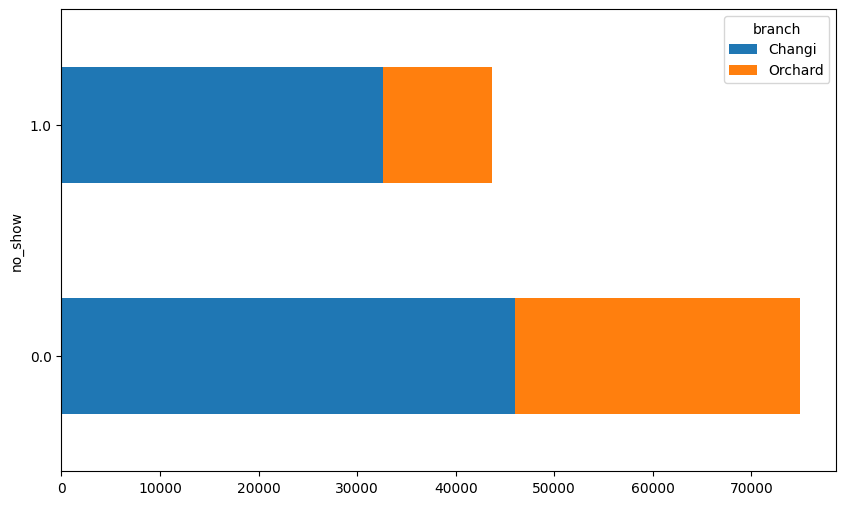

In [156]:
plt.figure(figsize = (10,8))
count_data = df.groupby(['no_show', 'branch']).size().unstack(fill_value=0)
count_data.plot(kind='barh', stacked=True, figsize=(10, 6))
plt.show()

In [157]:
branch_and_noshow = df.groupby('branch')['no_show'].value_counts(normalize=True).unstack().fillna(0)
branch_and_noshow

no_show,0.0,1.0
branch,,
Changi,0.585041,0.414959
Orchard,0.722896,0.277104


- The number of no-show reservations was about half that of reservations who actually showed up.
- As the branch at Changi had higher reservations overall, it also meant it had more no-show reservations. Changi also had a higher percentage of no-show reservations (41.5%) compared to Orchard.

In [158]:
country_and_noshow = df.groupby('country')['no_show'].value_counts(normalize=True).unstack().fillna(0)
country_and_noshow

no_show,0.0,1.0
country,,
Australia,0.797636,0.202364
China,0.437166,0.562834
India,0.779423,0.220577
Indonesia,0.732281,0.267719
Japan,0.828513,0.171487
Malaysia,0.645822,0.354178
Singapore,0.760563,0.239437


- Percentage of no-show reservations were generally similar for customers of different countries (around 20%). However, percentage of no-show reservations were higher for reservations from Malaysia (35.4%) and China (56.2%).

In [159]:
platform_and_noshow = df.groupby('platform')['no_show'].value_counts(normalize=True).unstack().fillna(0)
platform_and_noshow

no_show,0.0,1.0
platform,,
Agent,0.631280,0.368720
Email,0.626959,0.373041
Phone,0.638732,0.361268
Website,0.632770,0.367230


In [160]:
room_and_noshow = df.groupby('room')['no_show'].value_counts(normalize=True).unstack().fillna(0)
room_and_noshow

no_show,0.0,1.0
room,,
King,0.611141,0.388859
President Suite,0.669189,0.330811
Queen,0.683398,0.316602
Single,0.682547,0.317453


- The percentage of no-show reservations was generally consistent across all platforms and across all room types. Platform and room types might not be of influence to whether no-show reservations happened. 

In [161]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df['no_show'], df['room']))

if p < 0.05: 
    print("We reject the null hypothesis and conclude that there is significant relationship between room type and whether no-show cancellation occurs.")
else: 
    print("We do not reject the null hypothesis that there is no significant relationship between room type and whether no-show cancellation occurs.")

We reject the null hypothesis and conclude that there is significant relationship between room type and whether no-show cancellation occurs.


In [162]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df['no_show'], df['platform']))

if p < 0.05: 
    print("We reject the null hypothesis and conclude that there is significant relationship between platform and whether no-show cancellation occurs.")
else: 
    print("We do not reject the null hypothesis that there is no significant relationship between platform and whether no-show cancellation occurs.")

We do not reject the null hypothesis that there is no significant relationship between platform and whether no-show cancellation occurs.


- Based on chi-square test, there was significant relationship between room type and whether no-show cancellation occurs, but no significant relationship between platform and whether no-show cancellation occurs. 
- One might consider dropping platform but keeping room type when modelling whether no-show cancellation occurs.

In [163]:
first_and_noshow = df.groupby(['first_time'])['no_show'].value_counts(normalize=True).unstack().fillna(0)
first_and_noshow

no_show,0.0,1.0
first_time,,
No,0.855529,0.144471
Yes,0.624019,0.375981


- Reservations of first-time customers were more likely to lead to no-show reservations.

In [164]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df['no_show'], df['booking_month']))

if p < 0.05: 
    print("We reject the null hypothesis and conclude that there is significant relationship between booking month and whether no-show cancellation occurs.")
else: 
    print("We do not reject the null hypothesis that there is no significant relationship between booking month and whether no-show cancellation occurs.")

We reject the null hypothesis and conclude that there is significant relationship between booking month and whether no-show cancellation occurs.


In [165]:
book_and_noshow = df.groupby(['booking_month'])['no_show'].value_counts(normalize=True).unstack().fillna(0)
book_and_noshow

no_show,0.0,1.0
booking_month,,
1,0.651167,0.348833
2,0.662752,0.337248
3,0.637885,0.362115
4,0.609651,0.390349
5,0.648263,0.351737
6,0.593430,0.406570
7,0.605566,0.394434
8,0.638450,0.361550
9,0.620147,0.379853


In [166]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df['no_show'], df['arrival_month']))

if p < 0.05: 
    print("We reject the null hypothesis and conclude that there is significant relationship between arrival month and whether no-show cancellation occurs.")
else: 
    print("We do not reject the null hypothesis that there is no significant relationship between arrival month and whether no-show cancellation occurs.")

We reject the null hypothesis and conclude that there is significant relationship between arrival month and whether no-show cancellation occurs.


In [167]:
arrival_and_noshow = df.groupby(['arrival_month'])['no_show'].value_counts(normalize=True).unstack().fillna(0)
arrival_and_noshow

no_show,0.0,1.0
arrival_month,,
1,0.697639,0.302361
2,0.668459,0.331541
3,0.679245,0.320755
4,0.593688,0.406312
5,0.605468,0.394532
6,0.587916,0.412084
7,0.626170,0.373830
8,0.623047,0.376953
9,0.611801,0.388199


- Certain booking months and arrival months had higher cancellation percentage than others.

#### **Influence of Numerical Variables on no_show**

In [168]:
df['num_occupants'] = df['num_adults'] + df['num_children']
df['arrival_day'] = df['arrival_day'].astype(int)
df['checkout_day'] = abs(df['checkout_day'].astype(int))

current_year = 2020
df['arrival_date'] = pd.to_datetime(df.apply(lambda row: f"{current_year}-{row['arrival_month']}-{row['arrival_day']}", axis=1), format = 'mixed')
df['checkout_date'] = pd.to_datetime(df.apply(lambda row: f"{current_year}-{row['checkout_month']}-{row['checkout_day']}", axis=1), format = 'mixed')

df['stay_duration'] = (df['checkout_date'] - df['arrival_date']).dt.days 
df['stay_duration'] = df['stay_duration'].apply(lambda x: x + 366 if x<0 else x)

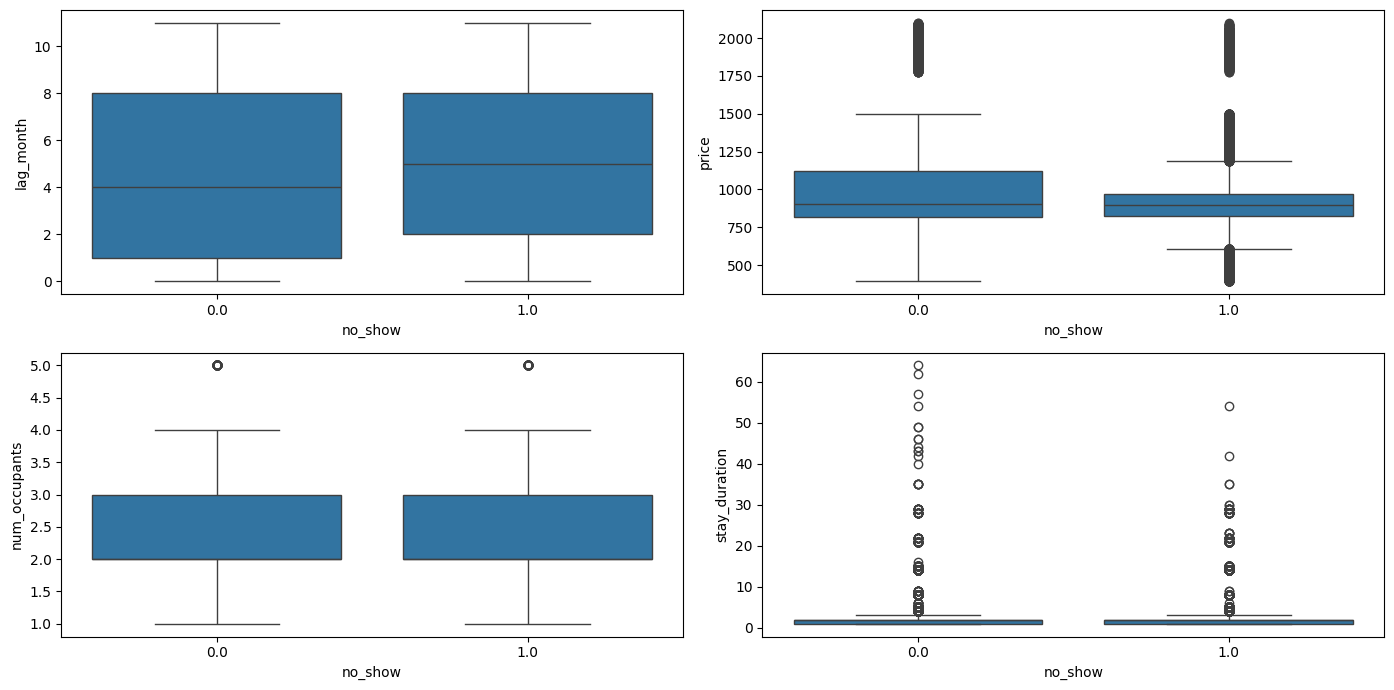

In [169]:
fig, axes = plt.subplots(2, 2, figsize=(14, 7))

sns.boxplot(ax=axes[0,0], x='no_show', y='lag_month', data=df)
sns.boxplot(ax=axes[0,1], x='no_show', y='price', data=df)
sns.boxplot(ax=axes[1,0], x='no_show', y='num_occupants', data=df)
sns.boxplot(ax=axes[1,1], x='no_show', y='stay_duration', data=df)

plt.tight_layout()
plt.show()

- No-show reservations had larger duration difference between booking month and arrival month on average. 

In [170]:
result = kruskal(df['no_show'], df['stay_duration'])
print(result)

KruskalResult(statistic=143773.2982741253, pvalue=0.0)


In [171]:
result = kruskal(df['no_show'], df['num_occupants'])
print(result)

KruskalResult(statistic=160190.56066609814, pvalue=0.0)


In [172]:
result = kruskal(df['no_show'], df['price'])
print(result)

KruskalResult(statistic=184837.12077578876, pvalue=0.0)


- According to Kruskal-Wallis test, median difference between booking month and arrival month, median number of occupants and median stay duration were different depending on whether no-show cancellations occured.

### **Features Used to Predict No-Show Cancellations**
**1. Categorical**
- branch
- booking_month
- arrival_month
- country: Where the customer came from.
- first_time: Whether it was the customer's first time at the hotel. 
- room

**2. Numerical**
- price: Price (per night) for the room booked. 
- num_occupants: Total number of adults and children.
- stay_duration: Difference (in number of days) between arrival and checkout date. 
- lag_month: Difference (in number of months) between booking and arrival date. 

In [173]:
df = df[['branch', 'booking_month', 'arrival_month', 'country', 'first_time', 'room', 'price', 'num_occupants', 'stay_duration', 'lag_month', 'no_show']]
df.head()

,branch,booking_month,arrival_month,country,first_time,room,price,num_occupants,stay_duration,lag_month,no_show
0,Changi,11,6,Singapore,Yes,Single,492.980000,1.0,2,7,0.0
1,Orchard,8,11,Indonesia,Yes,King,1351.220000,2.0,1,3,0.0
2,Changi,3,2,India,Yes,Single,482.568092,1.0,4,11,0.0
3,Orchard,9,10,China,Yes,Single,666.040000,1.0,2,1,1.0
4,Orchard,3,6,Australia,Yes,Queen,898.249500,1.0,4,3,0.0


### **Data Pre-Processing**
- One-hot encoding was applied to transform the categorical variables. 
- Standard scaling was applied to numerical variables to remove their mean and scale each variable to unit variance. 

In [174]:
X = df.drop('no_show', axis = 1)
y = df['no_show']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify=y, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (106718, 10)
Shape of X_test: (11858, 10)


In [175]:
categorical = ['branch', 'country', 'first_time', 'room']
encoder_dict = {}

for feature in categorical: 
    encoder = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)
    encoder.fit(X_train[[feature]])
    encoder_dict[feature] = encoder

    encoded_train = encoder.transform(X_train[[feature]])
    encoded_test = encoder.transform(X_test[[feature]])
    encoded_feature_names = encoder.get_feature_names_out([feature])

    encoded_train = pd.DataFrame(encoded_train, columns = encoded_feature_names, index = X_train.index)
    encoded_test = pd.DataFrame(encoded_test, columns = encoded_feature_names, index = X_test.index)

    X_train = X_train.drop(columns = [feature])
    X_test = X_test.drop(columns = [feature])

    X_train = pd.concat([X_train, encoded_train], axis = 1)
    X_test = pd.concat([X_test, encoded_test], axis = 1)

In [177]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns = X_train.columns, index = X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns = X_test.columns, index = X_test.index)

### **Machine Learning**
- We built two baseline machine learning models (logistic regression and K-nearest neighbours) to compare the performance of more advanced machine learning models. 
- We also built three advanced machine learning models: support vector machine, random forest and XGBoost. 

The above machine learning models were considered as they were common models used in binary classification tasks. 

1. Logistic regression
- Pros: Easy to implement and interpret and requires less computational power. 
- Cons: Assumes a linear relationship between independent variables and the log odds of the dependent variable, which may not always hold true.

2. K-nearest neighbours
- Pros: Easy to implement and does not make any assumption about data distribution. 
- Cons: Computationally intensive and slow for large datasets as it requires computing distance between query points and all points in the dataset. 

3. Support vector machine
- Pros: Robust to overfitting and works well with high-dimensional data. 
- Cons: Requires careful tuning of parameters (eg. gamma and choice of kernel). Computationally intensive for large datasets. 

4. Random forest
- Pros: High accuracy and robust to overfitting. 
- Cons: Computationally intensive and more difficult to interpret compared to a single decision tree. 

5. XGBoost
- Pros: High accuracy and offers a wide range of hyperparameters to tune the model. 
- Cons: Training requires significant memory and processing power. Difficult to tune and understand. 

We considered the recall metric to judge the performance of the machine learning models. 
- Recall explains how many of the actual predicted cases we were able to predict correctly with our model.
- It is useful in cases where false negatives are of a higher concern than false positives. This is true in the case of no-show cancellation since correct predictions of no-show cancellations allow hotel management to allocate the room originally reserved for the no-show customer to other customers, reducing the financial loss incurred. 

We also considered other accuracy metrics such as confusion matrix and AUC-ROC. The greater the AUC, the better is the performance of the model at different threshold points between negative and positive points.

#### **Logistic Regression**

Accuracy: 0.6314724236802158
Recall: 0.0
AUC-ROC: 0.5


<Axes: >

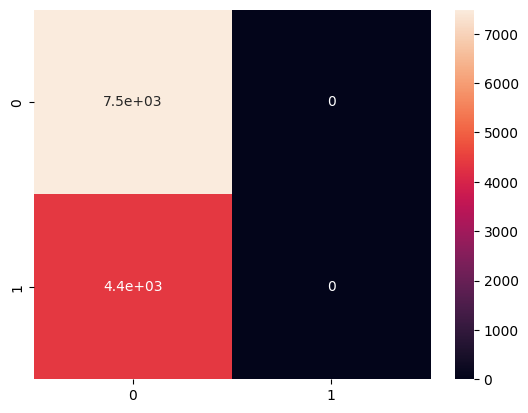

In [189]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}")

sns.heatmap(confusion_matrix(y_test, y_pred, labels = lr.classes_), annot = True)

- While logistic regression managed to classify correctly all reservations who showed up, it did not classify correctly any no-show cancellations. Logistic regression is a poor classifier for the task.

#### **K-Nearest Neighbours**

Maximum recall:- 0.0009153318077803204 at K = 4


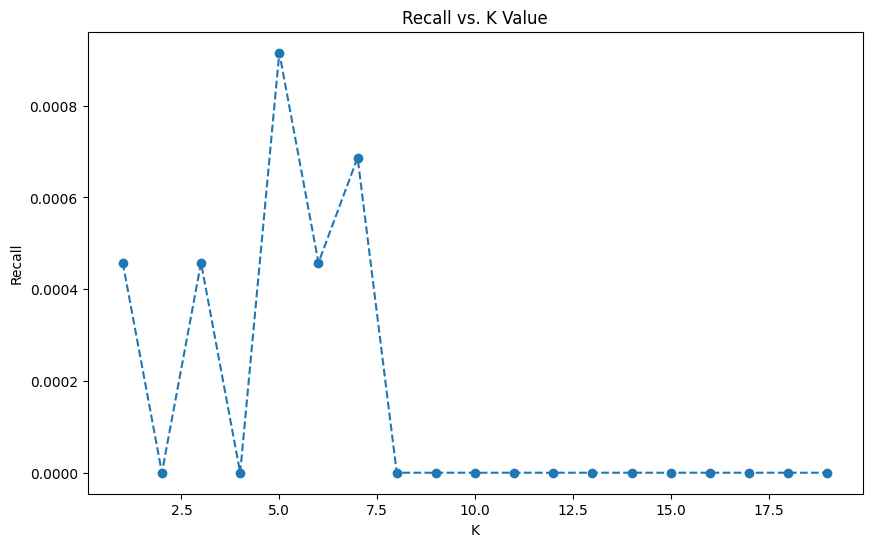

In [197]:
recall = []
for i in range(1,20):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 recall.append(recall_score(y_test, pred_i))


plt.figure(figsize=(10,6))
plt.plot(range(1,20),recall,linestyle='dashed', 
         marker='o')
plt.title('Recall vs. K Value')
plt.xlabel('K')
plt.ylabel('Recall')
print("Maximum recall:-",max(recall),"at K =",recall.index(max(recall)))

Accuracy: 0.6314724236802158
Recall: 0.0
AUC-ROC: 0.5


<Axes: >

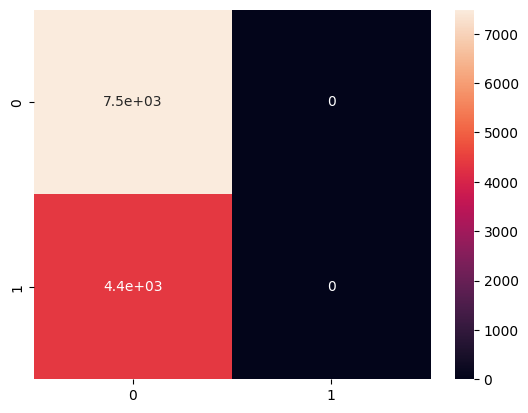

In [196]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}")

sns.heatmap(confusion_matrix(y_test, y_pred, labels = knn.classes_), annot = True)

- While K-nearest neighbours managed to classify correctly all reservations who showed up, it did not classify correctly any no-show cancellations.

#### **Support Vector Machine**

Accuracy: 0.6314724236802158
Recall: 0.0
AUC-ROC: 0.5


<Axes: >

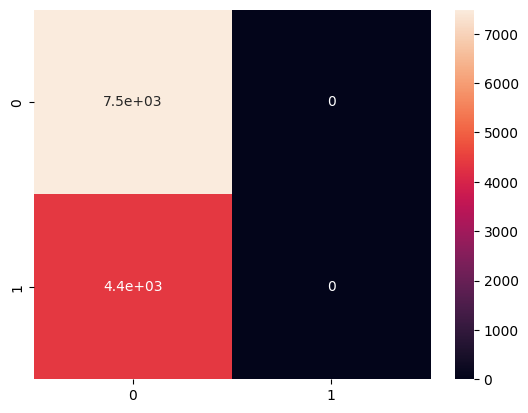

In [200]:
svm_default = svm.SVC()
svm_default.fit(X_train, y_train)
y_pred = svm_default.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}")

sns.heatmap(confusion_matrix(y_test, y_pred, labels = svm_default.classes_), annot = True)

- While support vector machines managed to classify correctly all reservations who showed up, it did not classify correctly any no-show cancellations.

#### **Random Forest Classifier**

Accuracy: 0.6899983133749368
Recall: 0.4826086956521739
AUC-ROC: 0.6468198392790785


<Axes: >

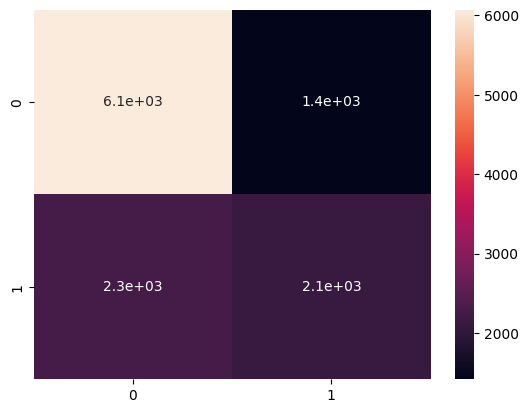

In [191]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}")

sns.heatmap(confusion_matrix(y_test, y_pred, labels = lr.classes_), annot = True)

- Random forest classified 50% of no-show cancellations correctly and did much better compared to logistic regression and KNN. 

#### **XGBoost**

Accuracy: 0.6235452858829482
Recall: 0.03501144164759725
AUC-ROC: 0.5010126652682431


<Axes: >

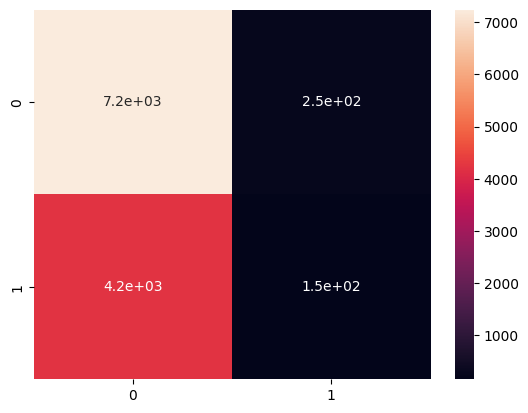

In [205]:
xgb = xgb.XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}")

sns.heatmap(confusion_matrix(y_test, y_pred, labels = lr.classes_), annot = True)

- XGBoost performed poorer in classifying correctly no-show cancellations compared to random forest. 
- The optimal model for classifying no-show cancellations is random forest classifier.

#### **Tuning Random Forest Classifier**
- Optuna was used to tune the hyperparameters of random forest classifer. The optimal set of hyperparameters was chosen based on when the recall metric was maximised.

In [210]:
def optimize_rf(trial): 
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200), 
        'max_depth': trial.suggest_int('max_depth', 3, 10), 
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10), 
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),
        'n_jobs': -1
    }
    
    rf = RandomForestClassifier(**params)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    recall = recall_score(y_test, y_pred)

    return recall

In [211]:
study = optuna.create_study(direction='maximize', study_name='xgb_study')
study.optimize(optimize_rf, n_trials=100, n_jobs=-1, show_progress_bar=True)

print(f"Best test recall: {study.best_value:.2%}")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

[I 2024-07-10 11:59:03,008] A new study created in memory with name: xgb_study
Best trial: 5. Best value: 0.608467:   1%|          | 1/100 [00:01<01:59,  1.20s/it]

[I 2024-07-10 11:59:04,073] Trial 5 finished with value: 0.608466819221968 and parameters: {'n_estimators': 10, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 5 with value: 0.608466819221968.


Best trial: 2. Best value: 0.612357:   2%|▏         | 2/100 [00:02<01:59,  1.22s/it]

[I 2024-07-10 11:59:05,243] Trial 2 finished with value: 0.6123569794050343 and parameters: {'n_estimators': 28, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:   3%|▎         | 3/100 [00:02<01:21,  1.19it/s]

[I 2024-07-10 11:59:05,706] Trial 7 finished with value: 0.608466819221968 and parameters: {'n_estimators': 32, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.6123569794050343.
[I 2024-07-10 11:59:05,736] Trial 0 finished with value: 0.6011441647597254 and parameters: {'n_estimators': 41, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:   5%|▌         | 5/100 [00:03<00:58,  1.61it/s]

[I 2024-07-10 11:59:06,619] Trial 4 finished with value: 0.608466819221968 and parameters: {'n_estimators': 67, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:   6%|▌         | 6/100 [00:06<01:44,  1.11s/it]

[I 2024-07-10 11:59:08,982] Trial 12 finished with value: 0.5798627002288329 and parameters: {'n_estimators': 42, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.6123569794050343.
[I 2024-07-10 11:59:09,166] Trial 6 finished with value: 0.608466819221968 and parameters: {'n_estimators': 138, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:   8%|▊         | 8/100 [00:06<00:58,  1.56it/s]

[I 2024-07-10 11:59:09,197] Trial 1 finished with value: 0.608466819221968 and parameters: {'n_estimators': 130, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:   9%|▉         | 9/100 [00:06<00:56,  1.60it/s]

[I 2024-07-10 11:59:09,942] Trial 8 finished with value: 0.4475972540045767 and parameters: {'n_estimators': 175, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  10%|█         | 10/100 [00:07<00:45,  1.96it/s]

[I 2024-07-10 11:59:10,181] Trial 9 finished with value: 0.4475972540045767 and parameters: {'n_estimators': 152, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  11%|█         | 11/100 [00:08<00:53,  1.68it/s]

[I 2024-07-10 11:59:10,973] Trial 3 finished with value: 0.608466819221968 and parameters: {'n_estimators': 183, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  12%|█▏        | 12/100 [00:09<01:21,  1.08it/s]

[I 2024-07-10 11:59:12,689] Trial 14 finished with value: 0.608466819221968 and parameters: {'n_estimators': 64, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.6123569794050343.
[I 2024-07-10 11:59:12,830] Trial 13 finished with value: 0.608466819221968 and parameters: {'n_estimators': 95, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  14%|█▍        | 14/100 [00:10<00:51,  1.67it/s]

[I 2024-07-10 11:59:13,304] Trial 10 finished with value: 0.608466819221968 and parameters: {'n_estimators': 193, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  15%|█▌        | 15/100 [00:10<00:44,  1.93it/s]

[I 2024-07-10 11:59:13,633] Trial 11 finished with value: 0.608466819221968 and parameters: {'n_estimators': 178, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  17%|█▋        | 17/100 [00:12<00:56,  1.47it/s]

[I 2024-07-10 11:59:15,464] Trial 16 finished with value: 0.608466819221968 and parameters: {'n_estimators': 140, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.6123569794050343.
[I 2024-07-10 11:59:15,490] Trial 17 finished with value: 0.608466819221968 and parameters: {'n_estimators': 89, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  18%|█▊        | 18/100 [00:13<01:03,  1.29it/s]

[I 2024-07-10 11:59:16,597] Trial 18 finished with value: 0.608466819221968 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  19%|█▉        | 19/100 [00:14<00:59,  1.35it/s]

[I 2024-07-10 11:59:17,190] Trial 15 finished with value: 0.608466819221968 and parameters: {'n_estimators': 144, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  20%|██        | 20/100 [00:16<01:34,  1.18s/it]

[I 2024-07-10 11:59:19,433] Trial 19 finished with value: 0.6091533180778032 and parameters: {'n_estimators': 110, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  21%|██        | 21/100 [00:16<01:13,  1.07it/s]

[I 2024-07-10 11:59:19,836] Trial 21 finished with value: 0.608466819221968 and parameters: {'n_estimators': 109, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  22%|██▏       | 22/100 [00:17<01:15,  1.03it/s]

[I 2024-07-10 11:59:20,867] Trial 22 finished with value: 0.608466819221968 and parameters: {'n_estimators': 112, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.6123569794050343.
[I 2024-07-10 11:59:20,928] Trial 20 finished with value: 0.608466819221968 and parameters: {'n_estimators': 114, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  24%|██▍       | 24/100 [00:18<00:50,  1.50it/s]

[I 2024-07-10 11:59:21,464] Trial 23 finished with value: 0.608466819221968 and parameters: {'n_estimators': 109, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  25%|██▌       | 25/100 [00:19<00:50,  1.48it/s]

[I 2024-07-10 11:59:22,194] Trial 24 finished with value: 0.608466819221968 and parameters: {'n_estimators': 120, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  26%|██▌       | 26/100 [00:19<00:44,  1.65it/s]

[I 2024-07-10 11:59:22,563] Trial 25 finished with value: 0.608466819221968 and parameters: {'n_estimators': 117, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  27%|██▋       | 27/100 [00:20<00:43,  1.69it/s]

[I 2024-07-10 11:59:23,160] Trial 26 finished with value: 0.608466819221968 and parameters: {'n_estimators': 122, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  28%|██▊       | 28/100 [00:22<01:13,  1.01s/it]

[I 2024-07-10 11:59:25,114] Trial 30 finished with value: 0.608466819221968 and parameters: {'n_estimators': 78, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  29%|██▉       | 29/100 [00:23<01:08,  1.04it/s]

[I 2024-07-10 11:59:25,920] Trial 27 finished with value: 0.608466819221968 and parameters: {'n_estimators': 115, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.6123569794050343.
[I 2024-07-10 11:59:26,114] Trial 31 finished with value: 0.608466819221968 and parameters: {'n_estimators': 77, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  31%|███       | 31/100 [00:23<00:41,  1.68it/s]

[I 2024-07-10 11:59:26,318] Trial 28 finished with value: 0.608466819221968 and parameters: {'n_estimators': 119, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  32%|███▏      | 32/100 [00:24<00:40,  1.67it/s]

[I 2024-07-10 11:59:26,852] Trial 32 finished with value: 0.608466819221968 and parameters: {'n_estimators': 81, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.6123569794050343.
[I 2024-07-10 11:59:27,006] Trial 34 finished with value: 0.608466819221968 and parameters: {'n_estimators': 67, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.6123569794050343.


[I 2024-07-10 11:59:27,172] Trial 33 finished with value: 0.608466819221968 and parameters: {'n_estimators': 84, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  35%|███▌      | 35/100 [00:24<00:24,  2.62it/s]

[I 2024-07-10 11:59:27,424] Trial 29 finished with value: 0.608466819221968 and parameters: {'n_estimators': 130, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  36%|███▌      | 36/100 [00:25<00:31,  2.05it/s]

[I 2024-07-10 11:59:28,364] Trial 41 finished with value: 0.608466819221968 and parameters: {'n_estimators': 10, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  37%|███▋      | 37/100 [00:28<01:10,  1.11s/it]

[I 2024-07-10 11:59:31,221] Trial 35 finished with value: 0.608466819221968 and parameters: {'n_estimators': 162, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  39%|███▉      | 39/100 [00:29<00:53,  1.13it/s]

[I 2024-07-10 11:59:32,505] Trial 36 finished with value: 0.608466819221968 and parameters: {'n_estimators': 159, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.6123569794050343.
[I 2024-07-10 11:59:32,590] Trial 37 finished with value: 0.608466819221968 and parameters: {'n_estimators': 160, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  40%|████      | 40/100 [00:30<00:53,  1.12it/s]

[I 2024-07-10 11:59:33,615] Trial 38 finished with value: 0.608466819221968 and parameters: {'n_estimators': 159, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  41%|████      | 41/100 [00:31<00:48,  1.23it/s]

[I 2024-07-10 11:59:34,160] Trial 40 finished with value: 0.608466819221968 and parameters: {'n_estimators': 156, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.6123569794050343.
[I 2024-07-10 11:59:34,242] Trial 39 finished with value: 0.608466819221968 and parameters: {'n_estimators': 164, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  44%|████▍     | 44/100 [00:31<00:26,  2.13it/s]

[I 2024-07-10 11:59:34,842] Trial 42 finished with value: 0.608466819221968 and parameters: {'n_estimators': 162, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.6123569794050343.
[I 2024-07-10 11:59:34,957] Trial 43 finished with value: 0.608466819221968 and parameters: {'n_estimators': 152, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  45%|████▌     | 45/100 [00:33<00:44,  1.23it/s]

[I 2024-07-10 11:59:36,717] Trial 48 finished with value: 0.608466819221968 and parameters: {'n_estimators': 32, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  46%|████▌     | 46/100 [00:34<00:38,  1.39it/s]

[I 2024-07-10 11:59:37,111] Trial 49 finished with value: 0.608466819221968 and parameters: {'n_estimators': 44, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  47%|████▋     | 47/100 [00:34<00:34,  1.55it/s]

[I 2024-07-10 11:59:37,533] Trial 50 finished with value: 0.608466819221968 and parameters: {'n_estimators': 44, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  48%|████▊     | 48/100 [00:34<00:28,  1.84it/s]

[I 2024-07-10 11:59:37,882] Trial 51 finished with value: 0.608466819221968 and parameters: {'n_estimators': 45, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  49%|████▉     | 49/100 [00:36<00:38,  1.32it/s]

[I 2024-07-10 11:59:39,197] Trial 52 finished with value: 0.608466819221968 and parameters: {'n_estimators': 54, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  50%|█████     | 50/100 [00:36<00:33,  1.51it/s]

[I 2024-07-10 11:59:39,576] Trial 44 finished with value: 0.608466819221968 and parameters: {'n_estimators': 193, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  51%|█████     | 51/100 [00:37<00:31,  1.55it/s]

[I 2024-07-10 11:59:40,222] Trial 46 finished with value: 0.608466819221968 and parameters: {'n_estimators': 200, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.6123569794050343.
[I 2024-07-10 11:59:40,429] Trial 47 finished with value: 0.5986270022883295 and parameters: {'n_estimators': 194, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  52%|█████▏    | 52/100 [00:37<00:24,  1.96it/s]

[I 2024-07-10 11:59:40,502] Trial 45 finished with value: 0.608466819221968 and parameters: {'n_estimators': 196, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  54%|█████▍    | 54/100 [00:38<00:19,  2.30it/s]

[I 2024-07-10 11:59:40,985] Trial 57 finished with value: 0.608466819221968 and parameters: {'n_estimators': 13, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  55%|█████▌    | 55/100 [00:38<00:20,  2.21it/s]

[I 2024-07-10 11:59:41,536] Trial 58 finished with value: 0.608466819221968 and parameters: {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.6123569794050343.
[I 2024-07-10 11:59:41,730] Trial 60 finished with value: 0.0 and parameters: {'n_estimators': 10, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  57%|█████▋    | 57/100 [00:38<00:12,  3.34it/s]

[I 2024-07-10 11:59:41,770] Trial 59 finished with value: 0.4302059496567506 and parameters: {'n_estimators': 16, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  58%|█████▊    | 58/100 [00:39<00:18,  2.24it/s]

[I 2024-07-10 11:59:42,655] Trial 54 finished with value: 0.608466819221968 and parameters: {'n_estimators': 189, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  60%|██████    | 60/100 [00:40<00:15,  2.59it/s]

[I 2024-07-10 11:59:43,290] Trial 53 finished with value: 0.608466819221968 and parameters: {'n_estimators': 190, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.6123569794050343.
[I 2024-07-10 11:59:43,453] Trial 63 finished with value: 0.5931350114416476 and parameters: {'n_estimators': 22, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.6123569794050343.
[I 2024-07-10 11:59:43,491] Trial 62 finished with value: 0.6016018306636156 and parameters: {'n_estimators': 26, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  62%|██████▏   | 62/100 [00:40<00:09,  4.19it/s]

[I 2024-07-10 11:59:43,558] Trial 64 finished with value: 0.608466819221968 and parameters: {'n_estimators': 26, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  64%|██████▍   | 64/100 [00:41<00:11,  3.18it/s]

[I 2024-07-10 11:59:44,368] Trial 55 finished with value: 0.608466819221968 and parameters: {'n_estimators': 198, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.6123569794050343.
[I 2024-07-10 11:59:44,488] Trial 65 finished with value: 0.6118993135011441 and parameters: {'n_estimators': 29, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  65%|██████▌   | 65/100 [00:41<00:12,  2.84it/s]

[I 2024-07-10 11:59:44,810] Trial 66 finished with value: 0.608466819221968 and parameters: {'n_estimators': 22, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  66%|██████▌   | 66/100 [00:42<00:16,  2.08it/s]

[I 2024-07-10 11:59:45,720] Trial 56 finished with value: 0.608466819221968 and parameters: {'n_estimators': 197, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  67%|██████▋   | 67/100 [00:43<00:16,  1.96it/s]

[I 2024-07-10 11:59:46,310] Trial 61 finished with value: 0.4475972540045767 and parameters: {'n_estimators': 180, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  70%|███████   | 70/100 [00:45<00:18,  1.65it/s]

[I 2024-07-10 11:59:48,769] Trial 69 finished with value: 0.608466819221968 and parameters: {'n_estimators': 130, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.6123569794050343.
[I 2024-07-10 11:59:48,840] Trial 67 finished with value: 0.6075514874141876 and parameters: {'n_estimators': 138, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.6123569794050343.
[I 2024-07-10 11:59:48,845] Trial 68 finished with value: 0.608466819221968 and parameters: {'n_estimators': 135, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  71%|███████   | 71/100 [00:46<00:16,  1.74it/s]

[I 2024-07-10 11:59:49,355] Trial 70 finished with value: 0.5796338672768879 and parameters: {'n_estimators': 135, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  72%|███████▏  | 72/100 [00:46<00:14,  1.89it/s]

[I 2024-07-10 11:59:49,679] Trial 71 finished with value: 0.608466819221968 and parameters: {'n_estimators': 95, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  73%|███████▎  | 73/100 [00:47<00:12,  2.09it/s]

[I 2024-07-10 11:59:50,113] Trial 72 finished with value: 0.608466819221968 and parameters: {'n_estimators': 103, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.6123569794050343.
[I 2024-07-10 11:59:50,231] Trial 73 finished with value: 0.608466819221968 and parameters: {'n_estimators': 94, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 2. Best value: 0.612357:  75%|███████▌  | 75/100 [00:47<00:09,  2.68it/s]

[I 2024-07-10 11:59:50,551] Trial 74 finished with value: 0.608466819221968 and parameters: {'n_estimators': 101, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.6123569794050343.


Best trial: 79. Best value: 0.613959:  76%|███████▌  | 76/100 [00:49<00:18,  1.31it/s]

[I 2024-07-10 11:59:52,355] Trial 79 finished with value: 0.6139588100686499 and parameters: {'n_estimators': 33, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 79 with value: 0.6139588100686499.


Best trial: 79. Best value: 0.613959:  77%|███████▋  | 77/100 [00:50<00:18,  1.24it/s]

[I 2024-07-10 11:59:53,260] Trial 82 finished with value: 0.608466819221968 and parameters: {'n_estimators': 35, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 79 with value: 0.6139588100686499.


Best trial: 79. Best value: 0.613959:  78%|███████▊  | 78/100 [00:50<00:16,  1.33it/s]

[I 2024-07-10 11:59:53,898] Trial 75 finished with value: 0.608466819221968 and parameters: {'n_estimators': 96, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 79 with value: 0.6139588100686499.


Best trial: 79. Best value: 0.613959:  80%|████████  | 80/100 [00:51<00:10,  1.83it/s]

[I 2024-07-10 11:59:54,479] Trial 76 finished with value: 0.608466819221968 and parameters: {'n_estimators': 101, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 79 with value: 0.6139588100686499.
[I 2024-07-10 11:59:54,659] Trial 77 finished with value: 0.608466819221968 and parameters: {'n_estimators': 98, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 79 with value: 0.6139588100686499.


Best trial: 79. Best value: 0.613959:  81%|████████  | 81/100 [00:51<00:08,  2.19it/s]

[I 2024-07-10 11:59:54,893] Trial 78 finished with value: 0.608466819221968 and parameters: {'n_estimators': 94, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 79 with value: 0.6139588100686499.


Best trial: 79. Best value: 0.613959:  82%|████████▏ | 82/100 [00:52<00:07,  2.50it/s]

[I 2024-07-10 11:59:55,096] Trial 81 finished with value: 0.608466819221968 and parameters: {'n_estimators': 65, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 79 with value: 0.6139588100686499.


Best trial: 79. Best value: 0.613959:  83%|████████▎ | 83/100 [00:53<00:10,  1.67it/s]

[I 2024-07-10 11:59:56,202] Trial 83 finished with value: 0.608466819221968 and parameters: {'n_estimators': 57, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 79 with value: 0.6139588100686499.


Best trial: 79. Best value: 0.613959:  84%|████████▍ | 84/100 [00:53<00:10,  1.57it/s]

[I 2024-07-10 11:59:56,872] Trial 84 finished with value: 0.608466819221968 and parameters: {'n_estimators': 54, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 79 with value: 0.6139588100686499.


Best trial: 79. Best value: 0.613959:  85%|████████▌ | 85/100 [00:54<00:09,  1.55it/s]

[I 2024-07-10 11:59:57,620] Trial 85 finished with value: 0.6041189931350115 and parameters: {'n_estimators': 59, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 79 with value: 0.6139588100686499.


Best trial: 86. Best value: 0.615561:  87%|████████▋ | 87/100 [00:55<00:07,  1.74it/s]

[I 2024-07-10 11:59:58,011] Trial 86 finished with value: 0.6155606407322655 and parameters: {'n_estimators': 54, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 86 with value: 0.6155606407322655.
[I 2024-07-10 11:59:58,031] Trial 89 finished with value: 0.608466819221968 and parameters: {'n_estimators': 37, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 86 with value: 0.6155606407322655.
[I 2024-07-10 11:59:58,060] Trial 87 finished with value: 0.608466819221968 and parameters: {'n_estimators': 55, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 86 with value: 0.6155606407322655.


Best trial: 86. Best value: 0.615561:  89%|████████▉ | 89/100 [00:55<00:03,  2.89it/s]

[I 2024-07-10 11:59:58,555] Trial 88 finished with value: 0.608466819221968 and parameters: {'n_estimators': 52, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 86 with value: 0.6155606407322655.


Best trial: 86. Best value: 0.615561:  90%|█████████ | 90/100 [00:55<00:03,  2.97it/s]

[I 2024-07-10 11:59:58,871] Trial 80 finished with value: 0.608466819221968 and parameters: {'n_estimators': 146, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 86 with value: 0.6155606407322655.


Best trial: 86. Best value: 0.615561:  91%|█████████ | 91/100 [00:56<00:04,  1.92it/s]

[I 2024-07-10 11:59:59,896] Trial 92 finished with value: 0.6153318077803204 and parameters: {'n_estimators': 38, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 86 with value: 0.6155606407322655.


Best trial: 86. Best value: 0.615561:  92%|█████████▏| 92/100 [00:57<00:04,  1.66it/s]

[I 2024-07-10 12:00:00,709] Trial 94 finished with value: 0.6155606407322655 and parameters: {'n_estimators': 39, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 86 with value: 0.6155606407322655.


Best trial: 86. Best value: 0.615561:  93%|█████████▎| 93/100 [00:58<00:04,  1.66it/s]

[I 2024-07-10 12:00:01,255] Trial 97 finished with value: 0.608466819221968 and parameters: {'n_estimators': 30, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 86 with value: 0.6155606407322655.


Best trial: 86. Best value: 0.615561:  94%|█████████▍| 94/100 [00:59<00:04,  1.21it/s]

[I 2024-07-10 12:00:02,678] Trial 93 finished with value: 0.6141876430205949 and parameters: {'n_estimators': 75, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 86 with value: 0.6155606407322655.


Best trial: 86. Best value: 0.615561:  95%|█████████▌| 95/100 [00:59<00:03,  1.54it/s]

[I 2024-07-10 12:00:02,877] Trial 96 finished with value: 0.608466819221968 and parameters: {'n_estimators': 69, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 86 with value: 0.6155606407322655.
[I 2024-07-10 12:00:02,948] Trial 95 finished with value: 0.608466819221968 and parameters: {'n_estimators': 73, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 86 with value: 0.6155606407322655.


Best trial: 86. Best value: 0.615561: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s]

[I 2024-07-10 12:00:03,577] Trial 98 finished with value: 0.6155606407322655 and parameters: {'n_estimators': 72, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 86 with value: 0.6155606407322655.
[I 2024-07-10 12:00:03,743] Trial 90 finished with value: 0.6135011441647598 and parameters: {'n_estimators': 148, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 86 with value: 0.6155606407322655.
[I 2024-07-10 12:00:03,769] Trial 91 finished with value: 0.608466819221968 and parameters: {'n_estimators': 145, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 86 with value: 0.6155606407322655.
[I 2024-07-10 12:00:03,770] Trial 99 finished with value: 0.6070938215102974 and parameters: {'n_estimators': 70, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 86 with value: 0.6155606407322655.
Best test recall: 61.56%
n_estimators: 54
max_depth: 10
min_samples_split: 10
min_

Accuracy: 0.6738910440209142
Recall: 0.608466819221968
AUC-ROC: 0.6602697343973088


<Axes: >

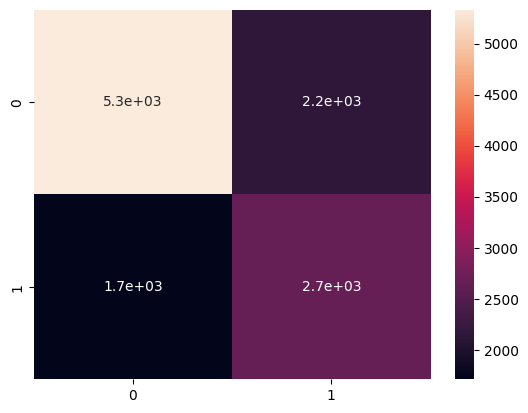

In [212]:
best_rf = RandomForestClassifier(**study.best_params, n_jobs=-1)
best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}")

sns.heatmap(confusion_matrix(y_test, y_pred, labels = lr.classes_), annot = True)

- Hyperparameter tuning increased the recall significantly from 0.48 to 0.61. 
- More no-show cancellations are classified correctly.